In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter

from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold, train_test_split, ParameterGrid

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning
import sksurv.util
import warnings
from lifelines.utils import k_fold_cross_validation
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.linear_model import ElasticNetCV,MultiTaskElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

from sksurv.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv("../1_data/private/preprocessed_data.csv")


In [175]:
df.columns

Index(['DonorID', 'Visit_Date', 'Visit_yr', 'Visit_Mo', 'donation_time',
       'don_Sequence', 'col_Int', 'Visit_Age', 'sex', 'Fixed', 'MobileID',
       'donation_product', 'DonProc', 'Outcome', 'ABO_RH',
       'Disease_marker_results', 'HB_Value', 'race_group', 'race', 'Ferritin',
       'category', 'DefCode', 'Def_start', 'Def_end', 'Deferral_permanent',
       'EffectiveYr', 'EffectiveMo', 'cum_lifetime_donations', 'unit_rbc_loss',
       'time_to_fu', 'rbc_loss_last_12_months', 'rbc_loss_last_24_months',
       'days_since_last_rbc_loss', 'days_since_last_drbc_loss', 'OUTCOME_TYPE',
       'CENSORED', 'time_to_return', 'Fixed_mobile', 'FIXED_NEXT',
       'fixed_mobile_pattern', 'first_time', 'high_school_age',
       'competing_events', 'NEXT_DON', 'PREV_DON', 'def_prod_imputed',
       'time_to_return2', 'def_Year', 'return_to_same_ID_by_dn',
       'return_to_same_ID', 'hgb_deferral', 'count_in_next_12_months',
       'Opp_to_donate'],
      dtype='object')

In [181]:
#for cox fitter
df_cox= df.loc[:,['time_to_return', 'CENSORED','Visit_Age', 'first_time' , 'Fixed_mobile' ,'sex', 'race', 'OUTCOME_TYPE', 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss', 'high_school_age', 'HB_Value',  'Opp_to_donate', 'ABO_RH' ]]

#'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss'
X=pd.get_dummies(df_cox)
X.fillna(0, inplace=True)
# add interactions
X['first_time*fixed']=X["first_time"]*X['Fixed_mobile']
X['first_time*hgb']=X["first_time"]*X['OUTCOME_TYPE_low hgb']
X['hgb*fixed']=X["OUTCOME_TYPE_low hgb"]*X['Fixed_mobile']

y= X[['CENSORED', 'time_to_return']]
#y= sksurv.util.Surv.from_dataframe('CENSORED', 'time_to_return', df_cox)

#split by pre-pandemic and intra pandmeic

# the date to divide the DataFrame
split_date = pd.to_datetime('2020-03-1')
df["Visit_Date"] = df["Visit_Date"].astype("datetime64")

# Create two subsets based on the split date
pre = df.loc[df['Visit_Date'] <= split_date]
intra = df.loc[df['Visit_Date'] > split_date]

#pre COVID
pre= pre.loc[:,['time_to_return', 'CENSORED','Visit_Age', 'first_time' , 'Fixed_mobile' ,'sex', 'race', 'OUTCOME_TYPE', 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss', 'high_school_age', 'count_in_next_12_months','HB_Value', 'ABO_RH']]
Xpre=pd.get_dummies(pre)
Xpre.fillna(0, inplace=True)
# add interactions
Xpre['first_time*fixed']=Xpre["first_time"]*Xpre['Fixed_mobile']
Xpre['first_time*hgb']=Xpre["first_time"]*Xpre['OUTCOME_TYPE_low hgb']
Xpre['hgb*fixed']=Xpre["OUTCOME_TYPE_low hgb"]*Xpre['Fixed_mobile']

ypre= Xpre[['CENSORED', 'time_to_return']]
#ypre= sksurv.util.Surv.from_dataframe('CENSORED', 'time_to_return', pre)

#Intra COVID
intra= intra.loc[:,['time_to_return', 'CENSORED','Visit_Age', 'first_time' , 'Fixed_mobile' ,'sex' ,'race', 'OUTCOME_TYPE', 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss', 'high_school_age', 'count_in_next_12_months', 'HB_Value', 'ABO_RH']]
Xintra=pd.get_dummies(intra)
Xintra.fillna(0, inplace=True)
# add interactions
Xintra['first_time*fixed']=Xintra["first_time"]*Xintra['Fixed_mobile']
Xintra['first_time*hgb']=Xintra["first_time"]*Xintra['OUTCOME_TYPE_low hgb']
Xintra['hgb*fixed']=Xintra["OUTCOME_TYPE_low hgb"]*Xintra['Fixed_mobile']

yintra= Xintra[['CENSORED', 'time_to_return']]
#yintra= sksurv.util.Surv.from_dataframe('CENSORED', 'time_to_return', intra)

pd.set_option('display.max_columns', 48)
X.head()


,time_to_return,CENSORED,Visit_Age,first_time,Fixed_mobile,cum_lifetime_donations,unit_rbc_loss,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,high_school_age,HB_Value,sex_F,sex_M,race_African Black,race_Asian,race_Mixed Race,race_White,race_unknown,OUTCOME_TYPE_completed,OUTCOME_TYPE_low hgb,OUTCOME_TYPE_no draw,OUTCOME_TYPE_other deferral,Opp_to_donate_12+,Opp_to_donate_3-6,Opp_to_donate_7-12,Opp_to_donate_Annual (1),Opp_to_donate_Bi-Annual (2),ABO_RH_A+,ABO_RH_A-,ABO_RH_AB+,ABO_RH_AB-,ABO_RH_B+,ABO_RH_B-,ABO_RH_O+,ABO_RH_O-,ABO_RH_UNK,first_time*fixed,first_time*hgb,hgb*fixed
0,323.0,1,40.9,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,16.0,1,41.9,0,1,23.0,1.0,1.0,2.0,379.0,3650.0,0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,12.0,1,42.1,0,1,24.0,1.0,2.0,3.0,72.0,3650.0,0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,11.0,1,42.3,0,1,25.0,1.0,3.0,4.0,68.0,3650.0,0,15.8,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3.0,1,42.5,0,1,26.0,1.0,4.0,5.0,67.0,3650.0,0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [182]:
X.columns

Index(['time_to_return', 'CENSORED', 'Visit_Age', 'first_time', 'Fixed_mobile',
       'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months',
       'rbc_loss_last_24_months', 'days_since_last_rbc_loss',
       'days_since_last_drbc_loss', 'high_school_age', 'HB_Value', 'sex_F',
       'sex_M', 'race_African Black', 'race_Asian', 'race_Mixed Race',
       'race_White', 'race_unknown', 'OUTCOME_TYPE_completed',
       'OUTCOME_TYPE_low hgb', 'OUTCOME_TYPE_no draw',
       'OUTCOME_TYPE_other deferral', 'Opp_to_donate_12+', 'Opp_to_donate_3-6',
       'Opp_to_donate_7-12', 'Opp_to_donate_Annual (1)',
       'Opp_to_donate_Bi-Annual (2)', 'ABO_RH_A+', 'ABO_RH_A-', 'ABO_RH_AB+',
       'ABO_RH_AB-', 'ABO_RH_B+', 'ABO_RH_B-', 'ABO_RH_O+', 'ABO_RH_O-',
       'ABO_RH_UNK', 'first_time*fixed', 'first_time*hgb', 'hgb*fixed'],
      dtype='object')

In [183]:
X.drop(['race_unknown',  'ABO_RH_UNK'], axis=1, inplace=True)
Xpre.drop(['race_unknown', 'ABO_RH_UNK'], axis=1, inplace=True)
Xintra.drop(['race_unknown', 'ABO_RH_UNK'], axis=1, inplace=True)

In [184]:
from sklearn.linear_model import ElasticNet
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

X_train1, X_test1, y_train1, y_test1 = train_test_split(Xpre, ypre, test_size=0.5, random_state=0)

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xintra, yintra, test_size=0.5, random_state=0)


Using gridsearch
MAE: -0.000
Config: {'alpha': 1e-05, 'l1_ratio': 0.52}

In [92]:
#cox = CoxnetSurvivalAnalysis()
#cox.fit(X_train, y_train)
X_train=X_train.drop('time_to_return', axis=1) 
y_train=y_train.drop('CENSORED', axis=1) 

X_train1=X_train1.drop('time_to_return', axis=1) 
y_train1=y_train1.drop('CENSORED', axis=1) 

X_train2=X_train2.drop('time_to_return', axis=1) 
y_train2=y_train2.drop('CENSORED', axis=1) 

X_test=X_test.drop('time_to_return', axis=1) 
y_test=y_test.drop('CENSORED', axis=1) 

X_test1=X_test1.drop('time_to_return', axis=1) 
y_test1=y_test1.drop('CENSORED', axis=1) 

X_test2=X_test2.drop('time_to_return', axis=1) 
y_test2=y_test2.drop('CENSORED', axis=1) 

In [191]:

cph = CoxPHFitter(l1_ratio=0.99, penalizer=0.01)
cph.fit(X, 'time_to_return', 'CENSORED')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4.04415e+06 total observations, 504142 right-censored observations>
             duration col = 'time_to_return'
                event col = 'CENSORED'
                penalizer = 0.01
                 l1 ratio = 0.99
      baseline estimation = breslow
   number of observations = 4.04415e+06
number of events observed = 3.54001e+06
   partial log-likelihood = -50198225.09
         time fit was run = 2023-09-25 17:13:08 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
Visit_Age                     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
first_time                   -0.06       0.94       0.00            -0.06            -0.06                 0.94                 0.95
Fixed_mobile                  0.34       1.41       0.00             0.34             0.35                 1.40                 1.41
cum_lifetime_donations        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
unit_rbc_loss                -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
rbc_loss_last_12_months       0.11       1.12       0.00             0.11             0.11                 1.12                 1.12
rbc_loss_last_24_months       0.06       1.06       0.00             0.06             0.06                 1.06                 1.06
days_since_last_rbc_loss     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
days_since_last_drbc_loss    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
high_school_age               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HB_Value                     -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
sex_F                        -0.01       0.99       0.07            -0.15             0.13                 0.86                 1.14
sex_M                         0.01       1.01       0.07            -0.13             0.15                 0.88                 1.16
race_African Black            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
race_Asian                   -0.08       0.92       0.00            -0.08            -0.08                 0.92                 0.93
race_Mixed Race               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
race_White                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OUTCOME_TYPE_completed       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OUTCOME_TYPE_low hgb          0.08       1.08       0.00             0.07             0.09                 1.08                 1.09
OUTCOME_TYPE_no draw         -0.08       0.92       0.00            -0.09            -0.07                 0.92                 0.93
OUTCOME_TYPE_other deferral   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Opp_to_donate_12+             0.22       1.25       0.00             0.21             0.22                 1.24                 1.25
Opp_to_donate_3-6             0.15       1.17       0.00             0.15             0.16                 1.16                 1.17
Opp_to_donate_7-12            0.13       1.14       0.00             0.13             0.14                 1.13                 1.15
Opp_to_donate_Annual (1)     -0.07       0.93       0.00            -0.08 

In [162]:

param_grid = {
    'penalizer': [0.001, 0.25, 0.5, 0.75, 1],  # Range of alpha values 
    'l1_ratio':[0.75]#np.arange(0, 1, 0.0) # Choose lasso - for variable selection
}

base_class = sklearn_adapter(CoxPHFitter, event_col='CENSORED')
cph = base_class(solver='newton-cg', tol=1e-4)

gcv = GridSearchCV(cph,
    param_grid=param_grid,
    cv=5,
    error_score='raise')


In [83]:
gcv.fit(X_train2, y_train2)

best_params = gcv.best_params_
best_model = gcv.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Print the summary of the best model
print("\nBest Model Summary:")
print(best_model.lifelines_model.print_summary())

KeyboardInterrupt: 

In [ ]:
print(best_model.lifelines_model.print_summary())

In [44]:
print(best_model.score(X_test, y_test))

0.6643379862727626


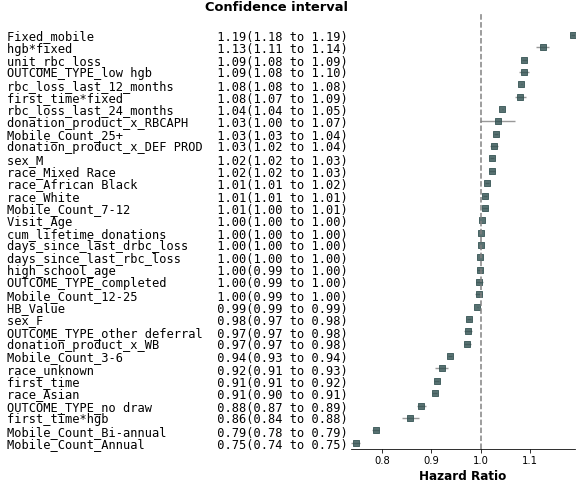

In [ ]:
from forestplot import forestplot
# Extract the coefficients and their confidence intervals

ci = cph.confidence_intervals_#.iloc[[2, 21, 22, 5, 4, 6, 23, 10, 16, 17, 14, 13, 11, 25, 19, 9, 8, 24, 18, 15, 20, 1],:]

coef = cph.hazard_ratios_
""""[['Fixed_mobile', 'OUTCOME_TYPE_no draw', "OUTCOME_TYPE_other deferral",
                           'rbc_loss_last_12_months','unit_rbc_loss','rbc_loss_last_24_months', 
                           'first_time*fixed',  'sex_M','race_Mixed Race',  'race_White', 
                           'race_African Black', 'donation_product_x_WB', 'donation_product_x_DEF PROD',
                           'hgb*fixed', 'OUTCOME_TYPE_completed', 'sex_F', 'high_school_age','first_time*hgb',
                           'race_unknown','race_Asian', 'OUTCOME_TYPE_low hgb', 'first_time']]"""

covariate=coef.index
"""['Fixed site (vs Mobile)', 'Outcome: No draw', 'Non-hemoglobin deferral',
             'RBC lost in past 12 months','Units of RBC lost',  'RBC lost in the last 24 months', 
            'First time donors at a fixed site (interaction term)', 'Male', 'Mixed race','Race: White',
         'Race: Black', 'Whole Blood Donation Product', 'Any Deferral', 'Hemoglobin Deferral at a Fixed Site (Interaction Term)',
         'Completed Donation', 'Female', "Age Group: <20, High School",'First Time Donors with HGB Deferral (Interaction Term)', 'Unknown race', 'Race: Asian', 'Hemoglobin Deferral', 'First Time Donors']"""

# Create a dataframe to store the coefficients and their confidence intervals
data = pd.DataFrame({'covariate': covariate, 'coef': coef, 'lower': ci['95% lower-bound'], 'upper': ci['95% upper-bound']})

data['lower'] = np.exp(data['lower'])
data['upper'] = np.exp(data['upper'])

# Sort the dataframe in descending order of coefficients
data = data.sort_values('coef', ascending=False)

# Create a numpy array of indices for each covariate
ind = np.arange(data.shape[0])


fp=forestplot(data,  # the dataframe with results data
              estimate="coef",  # col containing estimated effect size 
              ll="lower", hl="upper",  # columns containing conf. int. lower and higher limits
              varlabel="covariate",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Hazard Ratio",  # x-label title
             )
fp.axvline(x=1.00, linestyle='--', color='gray')
plt.show()

In [ ]:
# Set up LassoCV model to find optimal penalty
#model1 = MultiTaskLassoCV(cv=5, random_state=0)
#model1.fit(X_train, y_train)
# Get optimal penalty value
#penaltyL = model1.alpha_

#set up Elastinet CV to find optimal penalty
##model2= MultiTaskElasticNetCV(cv=5, random_state=0)
#model2.fit(X_train, y_train)
# Get optimal penalty value
#penaltyEN = model2.alpha_
#l1EN=model2.l1_ratio_


#set up 3 cox fiter

# Set up Cox model with ridge penalty
#cphR = CoxPHFitter(penalizer=penaltyR)
#cph = CoxPHFitter()
# Set up CoxPHFitter model with Lasso penalty
#cphL = CoxPHFitter(penalizer=penaltyL)
# Set up CoxPHFitter model with EN penalty
#cphEN = CoxPHFitter(penalizer=penaltyEN)




#fit all 3
#cph.fit(X_train3, duration_col='time_to_return', event_col='CENSORED')
#cphL.fit(X_train3, duration_col='time_to_return', event_col='CENSORED')
#cphEN.fit(X_train3, duration_col='time_to_return', event_col='CENSORED')

#compute score
#print(cph.score(X_test3, scoring_method='concordance_index'))
#print(cphL.score(X_test3, scoring_method='concordance_index'))
#print(cphEN.score(X_test3, scoring_method='concordance_index'))

#fit best model

# Use k-fold cross-validation to fit the model
"""
cph=cphL #lasso is the best performing

kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = []

for train_idx, val_idx in kf.split(X3):
    X_train_fold, X_val_fold = X3.iloc[train_idx], X3.iloc[val_idx]
    y_train_fold, y_val_fold = y3.iloc[train_idx], y3.iloc[val_idx]
    
    cph.fit(X_train_fold, duration_col='time_to_return', event_col='CENSORED')
    CV_score = cph.score(X_val_fold, scoring_method='concordance_index')
    scores.append(CV_score)

# Print average cross-validation score
print('Average cross-validation score:', sum(scores)/len(scores))


# Fit the model on the entire training set
#cph.fit(X_train3, duration_col='time_to_return', event_col='CENSORED')

# Print summary of the model
cph.print_summary()
"""